In [1]:
# Imports libraries for tiff loading, analysis, and plotting
import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import savgol_filter, find_peaks
from scipy.ndimage import label
from skimage.measure import block_reduce
from collections import defaultdict
plt.style.use('Jlab2.mplstyle') #for stylistic edits of graphs etc

In [12]:
#Loads the raw tiff file as a stacked numpy array (frames x width in pixels x height in pixels)
# Could be something that could be easily automated to go through all files in the folder
tif_stack = tiff.imread(r"C:\\Users\\teaching\\OneDrive - Nexus365\\ILESLA Y1 MODULES\\LSS STATS, DATA SCI & AI\\ILESLA\\Raw Data\\20251118_GRAB_ACh_WT_Male\\Slice 2 (DLS)\\Control\\_10\\_10_MMStack_Default.ome.tif")


# Loads the mask (a binary image) and convert it to a boolean array
# Essentially a crop, to get FIJI to focus on important bits
mask = tiff.imread(r"C:\Users\teaching\OneDrive - Nexus365\ILESLA Y1 MODULES\LSS STATS, DATA SCI & AI\ILESLA\Raw Data\20251118_GRAB_ACh_WT_Male\DLS Mask.tif").astype(bool)

(np.float64(-0.5), np.float64(29.5), np.float64(29.5), np.float64(-0.5))

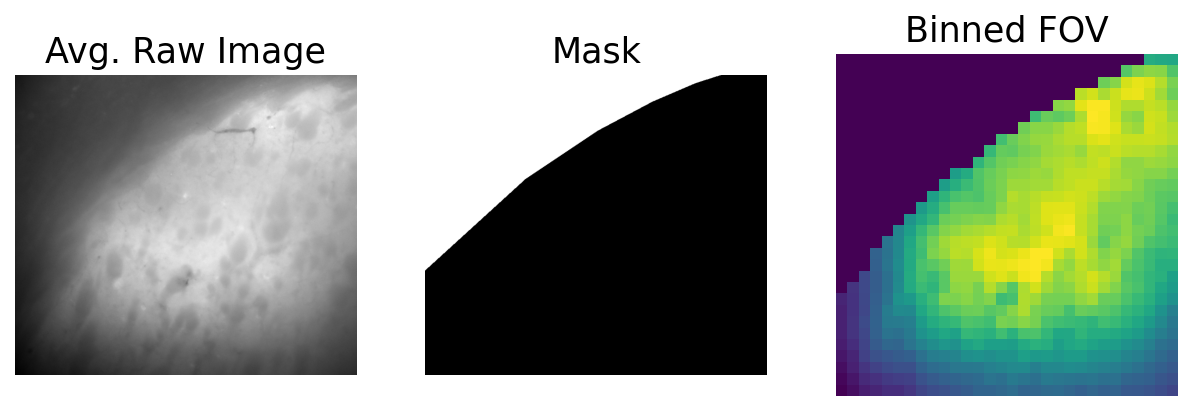

In [13]:
# Sets the number of spatial bins to segment x and y axes
# Could experiment with a different number of bins? 
bin_no = 30

# Applies the mask to set all masked pixels to NaN (non-value)
tif_stack_masked = np.where(mask, np.nan, tif_stack)

#  Defines bins along Y and X
num_bins_y, num_bins_x = bin_no, bin_no

# Computes bin size (pixels per bin in Y & X)
bin_size_y, bin_size_x = tif_stack_masked.shape[1] // num_bins_y, tif_stack_masked.shape[2] // num_bins_x

# Computes cropped height and width
cropped_height, cropped_width = bin_size_y * num_bins_y, bin_size_x * num_bins_x

# Crops the stack to divisible dimensions
cropped_stack = tif_stack_masked[:, :cropped_height, :cropped_width]

# Bins the stack using block averaging (ie averages all pixel values in 1 bin)
binned_stack = block_reduce(
    cropped_stack, 
    block_size=(1, bin_size_y, bin_size_x), 
    func=np.nanmean)

# Identifies masked bins
binned_mask = block_reduce(
    mask[:cropped_height, :cropped_width], 
    block_size=(bin_size_y, bin_size_x), 
    func=np.nanmax)

# Sets masked bins to NaN
binned_stack[:, binned_mask == 1] = np.nan

# Computes the minimum nonNaN bin value
# Sets the background 0 value
min_bin_value = np.nanmin(np.mean(binned_stack, axis=0))

# Replaces NaN values with the minimum value
# IE pretends that NaN values = lowest min background noise
binned_stack = np.nan_to_num(binned_stack, nan=min_bin_value)

fig, ax = plt.subplots(1,3, figsize=(10, 10))
# Plots the average projection of the raw tiff file across the full recording
ax[0].imshow(np.mean(tif_stack, axis=0), cmap='gray')
ax[0].set(title='Avg. Raw Image')
ax[0].axis('off')

# Plots the mask to show the area(s) excluded from subsequent analyses
ax[1].imshow(mask, cmap='gray')
ax[1].set(title='Mask')
ax[1].axis('off')

# Plots mean activity across the binned FOV (Field of View)
img = ax[2].imshow(np.mean(binned_stack, axis=0), cmap='viridis', aspect='auto')
ax[2].set_title('Binned FOV')
ax[2].set(xlabel='Bin', ylabel='Bin')
ax[2].set_aspect('equal')
ax[2].axis('off')

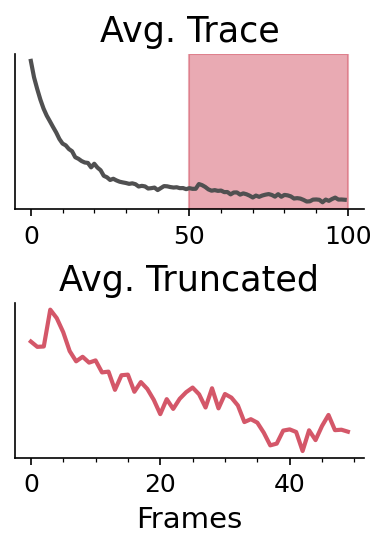

In [14]:
# Excludes the first n frames of data (i.e. exponential decay artefact) 
excluded_frames = 50
trunc_stack = binned_stack[excluded_frames:]

fig, ax = plt.subplots(2,1, figsize=(3,3.5))
ax[0].plot(binned_stack.mean(axis=(1,2)), linewidth=2)
ax[0].axvspan(excluded_frames, len(tif_stack), color='C1', alpha=0.5)
ax[0].get_yaxis().set_visible(False)
ax[0].set(title='Avg. Trace')

ax[1].plot(trunc_stack.mean(axis=(1,2)), color='C1', linewidth=2)
ax[1].get_yaxis().set_visible(False)
ax[1].set(title='Avg. Truncated', xlabel='Frames')

plt.subplots_adjust(hspace=0.6)

In [15]:
def sliding_dff(trunc_stack, window_size=100, percentile=8):
    """
    Calculate ΔF/F using a sliding window with a specified percentile.

    Parameters:
        trunc_stack (np.ndarray): 3D array of fluorescence data (frames, height, width).
        window_size (int): Number of frames in the sliding window (ensure longer than events).
        percentile (float): Percentile to calculate F₀ in each window.
    
    Returns:
        dff_stack (np.ndarray): ΔF/F normalized fluorescence data for each bin.
    """
    # Initialises F0 array
    F0_sliding = np.empty_like(trunc_stack)

    # Iterates over frames
    for frame in range(trunc_stack.shape[0]):
        # Defines the start and end of the window
        start_frame = max(0, frame - window_size)
        end_frame = min(trunc_stack.shape[0], frame + window_size)

        # Calculates the percentile for F0 (ignoring NaNs)
        F0_sliding[frame] = np.nanpercentile(
            trunc_stack[max(0, frame - window_size):max(1, frame)], percentile, axis=0
        )

    # Calculates ΔF/F
    dff_stack = (trunc_stack - F0_sliding) / F0_sliding
    
    return dff_stack

dff_stack = sliding_dff(trunc_stack)

# Gets the dimensions of the dff stack (frames, height, width)
_, binned_height, binned_width = dff_stack.shape

# Generates a list of all bin coordinates
bins = [(y, x) for y in range(binned_height) for x in range(binned_width)]

In [16]:
def detect_events(dff_stack, bins, filter_window=5, prominence=5, min_event_length=5, 
                  filter_polyorder=2, threshold=5, min_distance=2, frame_rate=10, percentile=90):

    aligned_events = []    # Creates a list to store merged (aligned) events
    all_event_frames = []  # Creates a list to store the frames of detected events

    for bin_coords in bins: # Scans through each bin in frame
        y, x = bin_coords
        trace = dff_stack[:, y, x]  # Extracts ΔF/F trace for this specific bin
        
        # Smooths the trace using a Savitzky-Golay filter
        smoothed_trace = savgol_filter(trace, window_length=int(filter_window), polyorder=filter_polyorder)
        
        # Computes percentile threshold and noise estimate (sigma via MAD)
        # Defines at which point a signal is classed as an event??
        percentile_threshold = np.nanpercentile(smoothed_trace, percentile)
        mad = np.nanmedian(np.abs(smoothed_trace - np.nanmedian(smoothed_trace))) + 1e-12
        sigma = 1.4826 * mad # A statistical trick to make MAD an unbiased estimator of stdev
        
        #Checks for understanding Sigma and MAD:
        #print("Sigma is:", sigma)
        #print("MAD is:", mad)
        
        # Detects peaks above threshold with required prominence and spacing
        peaks, _ = find_peaks(smoothed_trace, 
                              height=threshold * sigma,
                              prominence=prominence * sigma,
                              distance=min_distance)

        # Identifies event start/end around each peak
        for peak in peaks:
            start = peak                            # Search backward to event onset
            while start > 0 and smoothed_trace[start - 1] > percentile_threshold:
                start -= 1
            end = peak                              # Search forward to even offset
            while end < len(smoothed_trace) - 1 and smoothed_trace[end + 1] > percentile_threshold:
                end += 1
            if (end - start) >= min_event_length:   # Store only sufficiently long events
                all_event_frames.append((peak, start, end, bin_coords))

    # Sort all detected events by peak frame
    all_event_frames.sort(key=lambda x: x[0])  
    return all_event_frames


""""
    
    aligned_events = []  # Creates a list to store merged (aligned) events
    
    for peak_frame, start, end, bin_coords in all_event_frames:
        # Stores the details of the first event
        if not aligned_events:
            aligned_events.append({
                'start': int(start),
                'end': int(end),
                'bins': [bin_coords],
                'peak': int(peak_frame)  
            })
            continue

        last = aligned_events[-1]   # Most recent grouped event
        frame_range = 10            # Merge events whose peaks occur within ±10 frames
        if abs(peak_frame - last['peak']) <= frame_range:
            last['start'] = int(min(last['start'], start))   # Extend event start if needed
            last['end']   = int(max(last['end'], end))       # Extend event end if needed
            last['bins'].append(bin_coords)                  # Add contributing bin
        else:
            # Stores a new event
            aligned_events.append({
                'start': int(start),
                'end': int(end),
                'bins': [bin_coords],
                'peak': int(peak_frame)
            })
    print(aligned_events)
    print(len(aligned_events))
    return all_event_frames

"""

'"\n    \n    aligned_events = []  # Creates a list to store merged (aligned) events\n    \n    for peak_frame, start, end, bin_coords in all_event_frames:\n        # Stores the details of the first event\n        if not aligned_events:\n            aligned_events.append({\n                \'start\': int(start),\n                \'end\': int(end),\n                \'bins\': [bin_coords],\n                \'peak\': int(peak_frame)  \n            })\n            continue\n\n        last = aligned_events[-1]   # Most recent grouped event\n        frame_range = 10            # Merge events whose peaks occur within ±10 frames\n        if abs(peak_frame - last[\'peak\']) <= frame_range:\n            last[\'start\'] = int(min(last[\'start\'], start))   # Extend event start if needed\n            last[\'end\']   = int(max(last[\'end\'], end))       # Extend event end if needed\n            last[\'bins\'].append(bin_coords)                  # Add contributing bin\n        else:\n            # S

In [17]:
all_event_frames = detect_events(dff_stack, bins, filter_window=5, min_event_length=1,                    #Should this be greater???
                               prominence=6, threshold=5, min_distance=1, percentile=50)

In [22]:
###################### LAILA V2 #######################

# Input:
#   aligned_events = list of { 'start':..., 'end':..., 'bins': [(y,x), ...], 'peak':... }
# Output:
#   distinct_event_coords = { "event 1": [(y,x),...], "event 2": [...] }


# 1. PREPARE UNIQUE COORDINATE LISTS FOR LOOKUP
all_coords = []                              # Makes a list of all bins containing fluorescence
for peak_frame, start, end, bin_coords in all_event_frames:       # Adds all the event coordinates from the above bit to one easy to search list
    all_coords.append(bin_coords)      
coords_set = set(all_coords)                 # Makes the list a set for easier searching
coords_list = sorted(coords_set)             # For deterministic processing order, optional but helpful for understanding

# 2. SETUP DATA STRUCTURES
distinct_event_coords = {}                   # Maps event name to list of (y,x) bin locations
coord_to_event = {}                          # Maps (y,x) to the event name for adding extra bins to events in distinct_event_coords
next_event_id = 1

##MOVE TO NEXT CELL FROM HERE TO RUN SANJNA'S CODE

# # helper: parse numeric suffix from "event N" for deterministic merging choice
# def event_id_num(evname):
#     try:
#         return int(evname.split()[-1])
#     except Exception:
#         return float('inf')

# # 3. NEIGHBOUR OFFSETS FOR QUEEN ADJACENCY.... using Sanjna's updates
# from itertools import product
# neighbour_offsets = [(dy, dx) for dy, dx in product((-1,0,1), repeat=2) if (dy,dx) != (0,0)] 


In [23]:
##Need this class of UnionFind to UnionMerge groups of events as they grow - this is the more robust
#Run this before running the merge

class UnionFind:
    def __init__(self):
        self.parent = {}
        self.rank = {}

    def make(self, x):
        if x not in self.parent:
            self.parent[x] = x
            self.rank[x] = 0

    def find(self, x):
        # path compression
        if self.parent[x] != x:
            self.parent[x] = self.find(self.parent[x])
        return self.parent[x]

    def union(self, a, b):
        # union by rank
        ra = self.find(a)
        rb = self.find(b)
        if ra == rb:
            return ra
        if self.rank[ra] < self.rank[rb]:
            ra, rb = rb, ra
        self.parent[rb] = ra
        if self.rank[ra] == self.rank[rb]:
            self.rank[ra] += 1
        return ra

In [24]:
##Spatially separate the events now:
def spatial_segment(all_event_frames):

    from collections import defaultdict

    uf = UnionFind() #calls the class we defined above
    distinct_events = {}
    coord_to_group = {}
    counter = 1
    next_group_ID = 1

    for event in all_event_frames:
        if event not in distinct_events: #we may want to remove this if statement and just loop already depending on how this runs
            bin_y = event[3][0]
            bin_x = event[3][1]
            bin_coords = event[3]
            print(bin_coords) #just printing as a sanity check
            coord = (bin_y,bin_x)
            print(coord) #print this also a sa snity check - should match bin_coords above

            #will need to modify/delete this in the final code where we add in the time component:
            if coord in coord_to_group:
                continue
            
            #building the catchment range - currently we have hard-coded a range of 8 Queen neighbours
            catchment_range = [
                (bin_y, bin_x+1), (bin_y, bin_x-1), 
                (bin_y+1, bin_x+1), (bin_y+1, bin_x), 
                (bin_y-1, bin_x) , (bin_y-1, bin_x-1), 
                (bin_y-1, bin_x+1), (bin_y+1), (bin_x-1)]

            # find groups present in neighbours (may be zero, one, or multiple)
            neighbour_group_ids = {coord_to_group[n] for n in catchment_range if n in coord_to_group}
            
            #if any([b in distinct_events for b in catchment_range]):
            if not neighbour_group_ids:
                # no neighbour -> create new provisional group
                gid = next_group_ID
                next_group_ID += 1  
                uf.make(gid)
                coord_to_group[coord] = gid
                
            else:
                # pick one gid as anchor (first in set) and attach coord to it
                # then union all neighbour gids together so they become one set
                # Note: converting set to list gives deterministic order in Python >=3.7,
                # but we don't rely on order because union-find canonicalizes later.
                gids = list(neighbour_group_ids)
                anchor = gids[0]
                coord_to_group[coord] = anchor
                uf.make(anchor)  # in case it wasn't created (should be)
                for other in gids[1:]:
                    uf.make(other)
                    uf.union(anchor, other)
                # (anchor vs other order doesn't matter; uf keeps sets)

    # Second pass: canonicalize provisional gids -> root ids, relabel to contiguous 1..N
    # Build mapping provisional_gid -> root
    provgid_to_root = {}
    for gid in list(uf.parent.keys()):
        provgid_to_root[gid] = uf.find(gid)

    # Map each root to a new compact id (1..M)
    root_to_newid = {}
    new_next = 1
    for root in sorted(set(provgid_to_root.values())):
        root_to_newid[root] = new_next
        new_next += 1

    # Build final coord -> group_id mapping
    coord_to_new_group = {}
    for coord, prov_gid in coord_to_group.items():
        root = provgid_to_root[prov_gid]
        final_gid = root_to_newid[root]
        coord_to_new_group[coord] = final_gid

    # Build groups dict (final_gid -> list coords)
    groups = defaultdict(list)
    for coord, gid in coord_to_new_group.items():
        groups[gid].append(coord)

    groups = {gid: sorted(coords) for gid, coords in groups.items()}

    # Build member_assignments aligned with all_event_frames
    member_assignments = []
    for ev in all_event_frames:
        try:
            _, _, _, bin_coords = ev
        except Exception:
            bin_coords = None

        if bin_coords is None:
            member_assignments.append(None)
            continue

        coord = (int(bin_coords[0]), int(bin_coords[1]))
        member_assignments.append(coord_to_new_group.get(coord, None))

    return groups, member_assignments, coord_to_new_group